In [68]:
# Import the libraries
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns

import torch.nn.functional as F
from tqdm import tqdm

In [69]:
# Which pre-trained model to use.
checkpoint = "microsoft/deberta-v3-small"     

In [70]:
# Checking whether you are running on CPU or GPU.
# If the output here says "cuda" then it's running on GPU. Otherwise it's probably CPU.
# In order to run your code in Colab on the GPU, go to Edit -> Notebook settings -> Hardware accelerator and set it to "GPU".
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [71]:
test_dataset_path ="../dataset/dpm_pcl_test.csv"
test_dataset = pd.read_csv(test_dataset_path)

test_dataset.head()

,par_id,art_id,keyword,country,text,orig_label
0,107,@@16900972,homeless,ke,"His present "" chambers "" may be quite humble ,...",3
1,149,@@1387882,disabled,us,Krueger recently harnessed that creativity to ...,2
2,151,@@19974860,poor-families,in,10:41am - Parents of children who died must ge...,3
3,154,@@20663936,disabled,ng,When some people feel causing problem for some...,4
4,157,@@21712008,poor-families,ca,We are alarmed to learn of your recently circu...,4


In [72]:
test_dataset["label"] = test_dataset["orig_label"].apply(lambda x : 0 if (x == 0 or x == 1) else 1)

test_dataset.loc[test_dataset["text"].isna(), "text"] = ""

set_uncased = False
if set_uncased:
    test_dataset['text'] = test_dataset['text'].str.lower()

#test_dataset = test_dataset.drop(['par_id', 'art_id', 'keyword', 'country', 'orig_label'], axis=1)
test_dataset = test_dataset.drop(['par_id', 'art_id', 'country'], axis=1)

test_dataset.head()

,keyword,text,orig_label,label
0,homeless,"His present "" chambers "" may be quite humble ,...",3,1
1,disabled,Krueger recently harnessed that creativity to ...,2,1
2,poor-families,10:41am - Parents of children who died must ge...,3,1
3,disabled,When some people feel causing problem for some...,4,1
4,poor-families,We are alarmed to learn of your recently circu...,4,1


In [73]:
# Perform tokenization
tokenizer = AutoTokenizer.from_pretrained(checkpoint, model_max_length=512)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=512)

raw_datasets_test = Dataset.from_pandas(test_dataset[['text', 'label']])

tokenized_datasets_test = raw_datasets_test.map(tokenize_function, batched=True, remove_columns=['text'])

# DataCollatorWithPadding constructs batches that are padded to the length of the longest sentence in the batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/vol/bitbucket/sg2121/nlp/NLP-CW/nlpenv/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/2094 [00:00<?, ? examples/s]

In [74]:
# Load the model's state
def load_model(model, filename):
    model_dir = "../models/saved_models/"
    saved_model = torch.load(model_dir + filename)
    model.load_state_dict(saved_model["model_state_dict"])

# Load the model hyperparameters and losses
def load_model_info(filename):
    model_dir = "../models/saved_losses/"
    with open(model_dir + filename, "rb") as f:
        info = pickle.load(f)
        
    return info["train_losses"], info["val_losses"], info["hyperparams"]

# This method will allow us to evaluate the model on the provided dataset
def evaluate_and_save_results(model, eval_dataloader, tokenizer, dataset):
    model.eval()
    predictions, targets, confidences, lengths, texts, keywords = [], [], [], [], [], []

    with torch.no_grad():
        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass
            outputs = model(**batch)
            logits = outputs.logits
            probs = F.softmax(logits, dim=-1)  # Convert logits to probabilities
            
            # Store predictions and confidence scores
            pred_labels = logits.argmax(dim=-1).cpu().numpy()
            true_labels = batch["labels"].cpu().numpy()
            confidence_scores = probs.max(dim=-1)[0].cpu().numpy()  # Highest softmax score
            
            # Store sequence lengths (count non-padding tokens)
            input_lengths = (batch["input_ids"] != tokenizer.pad_token_id).sum(dim=1).cpu().numpy()
            
            predictions.extend(pred_labels)
            targets.extend(true_labels)
            confidences.extend(confidence_scores)
            lengths.extend(input_lengths)

    # Create DataFrame with evaluation results
    eval_df = pd.DataFrame({
        "text": dataset["text"],  # Raw text from dataset
        "true_label": targets,
        "pred_label": predictions,
        "confidence": confidences,
        "length": lengths,
        "keyword": dataset["keyword"] if "keyword" in dataset.columns else None,
        "orig_label": dataset["orig_label"] if "orig_label" in dataset.columns else None
    })
    
    print(classification_report(targets, predictions))
    
    # Save to CSV
    eval_df.to_csv("../models/saved_models/saved_model_outputs.csv", index=False)
    print("Results saved to saved_model_outputs.csv")


In [75]:
# Load the pretrained model 
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
model = model.to(device)

load_model(model, "deberta_with_preprocessing_and_synonym_replacement.pth")

# Load the test dataset
test_dataloader = DataLoader(
    tokenized_datasets_test, batch_size=8, collate_fn=data_collator
)

# Evaluate the model on the test set
evaluate_and_save_results(model, test_dataloader, tokenizer, test_dataset)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|████████████████████████████████████████████████████████████████████| 262/262 [00:19<00:00, 13.23it/s]

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1895
           1       0.59      0.52      0.55       199

    accuracy                           0.92      2094
   macro avg       0.77      0.74      0.75      2094
weighted avg       0.92      0.92      0.92      2094

Results saved to saved_model_outputs.csv


In [76]:
# Load saved results (modify file paths as needed)
results = pd.read_csv("../models/saved_models/saved_model_outputs.csv") 

results.head()

,text,true_label,pred_label,confidence,length,keyword,orig_label
0,"His present "" chambers "" may be quite humble ,...",1,0,0.875130,80,homeless,3
1,Krueger recently harnessed that creativity to ...,1,0,0.579440,58,disabled,2
2,10:41am - Parents of children who died must ge...,1,0,0.592085,30,poor-families,3
3,When some people feel causing problem for some...,1,1,0.614998,110,disabled,4
4,We are alarmed to learn of your recently circu...,1,0,0.825851,108,poor-families,4


/tmp/ipykernel_386452/897589436.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=accuracy_per_label["orig_label"], y=accuracy_per_label["correct"], palette="viridis")


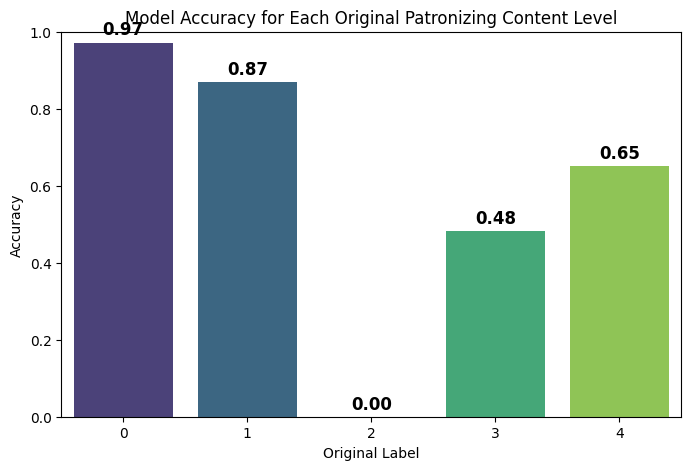

In [77]:
# 1. Model Performance vs. Patronizing Content Level

# Compute accuracy per original label
results["correct"] = (results["true_label"] == results["pred_label"]).astype(int)

# Group by `orig_label` and compute mean accuracy
accuracy_per_label = results.groupby("orig_label")["correct"].mean().reset_index()

# Plot the accuracy for each original label
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=accuracy_per_label["orig_label"], y=accuracy_per_label["correct"], palette="viridis")

# Label the axes and title
plt.xlabel("Original Label")
plt.ylabel("Accuracy")
plt.title("Model Accuracy for Each Original Patronizing Content Level")
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.xticks([0, 1, 2, 3, 4])  # Ensure all labels are shown

for index, row in accuracy_per_label.iterrows():
    ax.text(row["orig_label"], row["correct"] + 0.02, f"{row['correct']:.2f}", 
            ha='center', fontsize=12, fontweight='bold')

# Show the plot
plt.show()

/tmp/ipykernel_386452/4168874878.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_per_bin = results.groupby("length_bin").apply(lambda x: accuracy_score(x["true_label"], x["pred_label"]))
/vol/bitbucket/sg2121/nlp/NLP-CW/nlpenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/vol/bitbucket/sg2121/nlp/NLP-CW/nlpenv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_386452/4168874878.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operatio

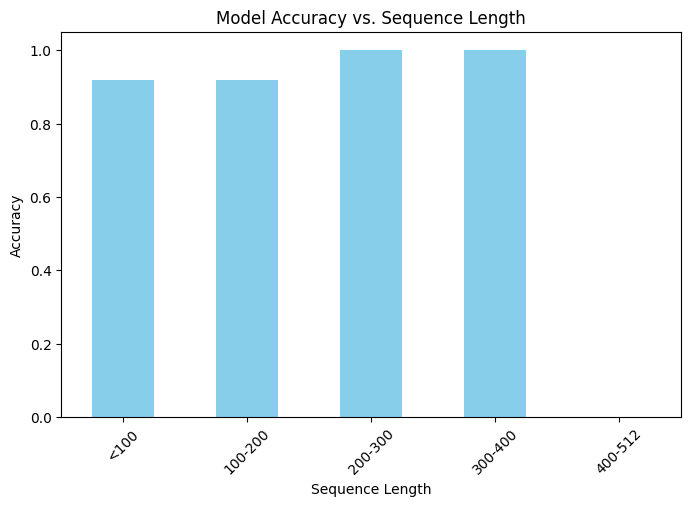

In [78]:
# 2. Input Sequence Length vs. Accuracy
bins = [0, 100, 200, 300, 400, 512]  # Define sequence length bins
labels = ['<100', '100-200', '200-300', '300-400', '400-512']
results["length_bin"] = pd.cut(results["length"], bins=bins, labels=labels)

accuracy_per_bin = results.groupby("length_bin").apply(lambda x: accuracy_score(x["true_label"], x["pred_label"]))

plt.figure(figsize=(8, 5))
accuracy_per_bin.plot(kind="bar", color="skyblue")
plt.xlabel("Sequence Length")
plt.ylabel("Accuracy")
plt.title("Model Accuracy vs. Sequence Length")
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_386452/306224055.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  category_accuracy = results.groupby("keyword").apply(lambda x: accuracy_score(x["true_label"], x["pred_label"]))


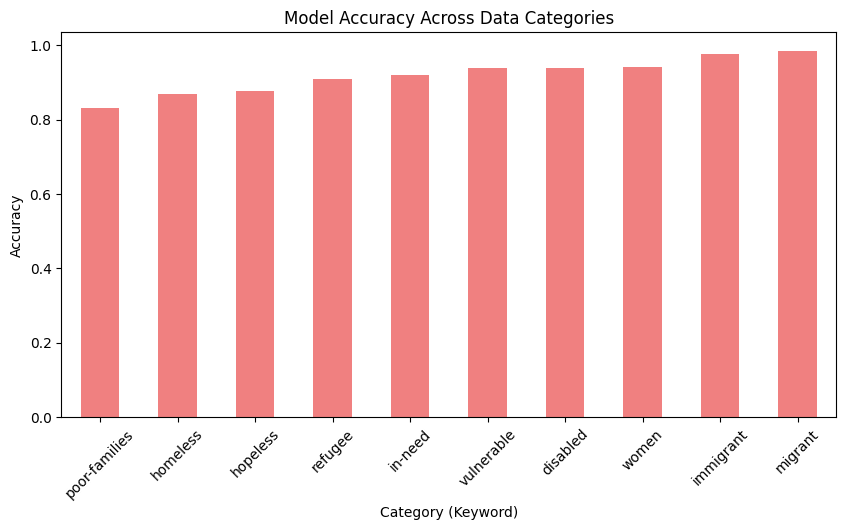

In [79]:
# 3. Model Performance Across Data Categories
category_accuracy = results.groupby("keyword").apply(lambda x: accuracy_score(x["true_label"], x["pred_label"]))

plt.figure(figsize=(10, 5))
category_accuracy.sort_values().plot(kind="bar", color="lightcoral")
plt.xlabel("Category (Keyword)")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Across Data Categories")
plt.xticks(rotation=45)
plt.show()
